# Introduction: Home Credit Default Risk Competition

# NOTEBOOK - 1 : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction


# Data

The data is provided by [Home Credit](http://www.homecredit.net/about-us.aspx)

There are 7 different sources of data:

* application_train/application_test: the main training and testing data with information about each loan application at Home Credit. Every loan has its own row and is identified by the feature `SK_ID_CURR`. The training application data comes with the `TARGET` indicating 0: the loan was repaid or 1: the loan was not repaid.
* bureau: data concerning client's previous credits from other financial institutions. Each previous credit has its own row in bureau, but one loan in the application data can have multiple previous credits.
* bureau_balance: monthly data about the previous credits in bureau. Each row is one month of a previous credit, and a single previous credit can have multiple rows, one for each month of the credit length.
* previous_application: previous applications for loans at Home Credit of clients who have loans in the application data. Each current loan in the application data can have multiple previous loans. Each previous application has one row and is identified by the feature `SK_ID_PREV`.
* POS_CASH_BALANCE: monthly data about previous point of sale or cash loans clients have had with Home Credit. Each row is one month of a previous point of sale or cash loan, and a single previous loan can have many rows.
* credit_card_balance: monthly data about previous credit cards clients have had with Home Credit. Each row is one month of a credit card balance, and a single credit card can have many rows.
* installments_payment: payment history for previous loans at Home Credit. There is one row for every made payment and one row for every missed payment.

This diagram shows how all of the data is related:

##### Metric: ROC AUC 


In [61]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [ ]:
import lightgbm as lgb

## Read in Data

Using only Application_Train and Application_test in this half of the notebook 

In [ ]:
%cd /content/drive/My Drive/KaggleTraining/Data

In [ ]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

The training data has 307511 observations (each one a separate loan) and 122 features (variables) including the `TARGET` (the label we want to predict).

In [ ]:
# Testing data features
app_test = pd.read_csv('application_test.csv')
print('Testing data shape: ', app_test.shape)
app_test.head()

The test set is considerably smaller and lacks a `TARGET` column.

# Exploratory Data Analysis


## Examine the Distribution of the Target Column

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

In [ ]:
app_train['TARGET'].value_counts()

In [ ]:
app_train['TARGET'].astype(int).plot.hist();

## Missing Values



In [ ]:
# Function to calculate missing values by column# Funct
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()

        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
def remove_missing_columns(train, test, threshold = 90):
    # Calculate missing stats for train and test (remember to calculate a percent!)
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)
    
    # list of missing columns for train and test
    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])
    
    # Combine the two lists together
    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    # Print information
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    # Drop the missing columns and return
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [ ]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

## Column Types
 Number of columns of each data type. `int64` and `float64` are numeric variables ([which can be either discrete or continuous](https://stats.stackexchange.com/questions/206/what-is-the-difference-between-discrete-data-and-continuous-data)). `object` columns contain strings and are  [categorical features.](http://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/what-are-categorical-discrete-and-continuous-variables/) .

In [ ]:
# Number of each type of column
app_train.dtypes.value_counts()

Number of unique entries in each of the `object` (categorical) columns.

In [ ]:
# Number of unique classes in each object column
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

## Encoding Categorical Variables


### Label Encoding and One-Hot Encoding

policy described above: for any categorical variable (`dtype == object`) with 2 unique categories, we will use label encoding, and for any categorical variable with more than 2 unique categories, we will use one-hot encoding.



In [ ]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])

            # Keep track of how many columns were label encoded
            le_count += 1

print('%d columns were label encoded.' % le_count)

In [ ]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

### Aligning Training and Testing Data



In [ ]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels
print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

## Exploratory Data Analysis

### Anomalies




In [ ]:
(app_train['DAYS_BIRTH'] / -365).describe()

Those ages look reasonable. There are no outliers for the age on either the high or low end. How about the days of employment?

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

In [ ]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [ ]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

In [ ]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [ ]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

### Correlations

* .00-.19 “very weak”
*  .20-.39 “weak”
*  .40-.59 “moderate”
*  .60-.79 “strong”
* .80-1.0 “very strong”


In [ ]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

### Effect of Age on Repayment

In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

In [ ]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age of Client'); plt.xlabel('Age (years)'); plt.ylabel('Count');

In [ ]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

In [ ]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Exterior Sources

The 3 variables with the strongest negative correlations with the target are `EXT_SOURCE_1`, `EXT_SOURCE_2`, and `EXT_SOURCE_3`.
these features represent a "normalized score from external data source".
 correlations of the `EXT_SOURCE` features with the target and with each other.

In [ ]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

In [ ]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

All three `EXT_SOURCE` featureshave negative correlations with the target, indicating that as the value of the `EXT_SOURCE` increases, the client is more likely to repay the loan. We can also see that `DAYS_BIRTH` is positively correlated with `EXT_SOURCE_1` indicating that maybe one of the factors in this score is the client age.

In [ ]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):

    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)


## Pairs Plot

As a final exploratory plot, we can make a pairs plot of the `EXT_SOURCE` variables and the `DAYS_BIRTH` variable. The [Pairs Plot](https://towardsdatascience.com/visualizing-data-with-pair-plots-in-python-f228cf529166) is a great exploration tool because it lets us see relationships between multiple pairs of variables as well as distributions of single variables. Here we are using the seaborn visualization library and the PairGrid function to create a Pairs Plot with scatterplots on the upper triangle, histograms on the diagonal, and 2D kernel density plots and correlation coefficients on the lower triangle.

If you don't understand this code, that's all right! Plotting in Python can be overly complex, and for anything beyond the simplest graphs, I usually find an existing implementation and adapt the code (don't repeat yourself)!

In [ ]:
# Copy the data for plotting
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()

# Add in the age of the client in years
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

# Drop na values and limit to first 100000 rows
plot_data = plot_data.dropna().loc[:100000, :]

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = plot_data, diag_sharey=False, hue = 'TARGET', vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

# Upper is a scatter plot
grid.map_upper(plt.scatter, alpha = 0.2)

# Diagonal is a histogram
grid.map_diag(sns.kdeplot)

# Bottom is density plot
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

In this plot, the red indicates loans that were not repaid and the blue are loans that are paid. We can see the different relationships within the data. There does appear to be a moderate positive linear relationship between the `EXT_SOURCE_1` and the `DAYS_BIRTH` (or equivalently `YEARS_BIRTH`), indicating that this feature may take into account the age of the client.

# Feature Engineering

* Polynomial features
* Domain knowledge features


## Polynomial Features

One simple feature construction method is called [polynomial features](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html). In this method, we make features that are powers of existing features as well as interaction terms between existing features. For example, we can create variables `EXT_SOURCE_1^2` and `EXT_SOURCE_2^2` and also variables such as `EXT_SOURCE_1` x `EXT_SOURCE_2`, `EXT_SOURCE_1` x `EXT_SOURCE_2^2`, `EXT_SOURCE_1^2` x   `EXT_SOURCE_2^2`, and so on. These features that are a combination of multiple individual variables are called [interaction terms](https://en.wikipedia.org/wiki/Interaction_(statistics) because they  capture the interactions between variables. 


In [ ]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.impute import SimpleImputer as Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures

# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [ ]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

This creates a considerable number of new features. To get the names we have to use the polynomial features `get_feature_names` method.

In [ ]:
poly_transformer.get_feature_names_out(input_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

In [ ]:
# Create a dataframe of the features
poly_features = pd.DataFrame(poly_features,
                             columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. When we build machine learning models, we can try with and without these features to determine if they actually help the model learn.

We will add these features to a copy of the training and testing data and then evaluate models with and without the features. Many times in machine learning, the only way to know if an approach will work is to try it out!

In [ ]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test,
                                  columns = poly_transformer.get_feature_names_out(['EXT_SOURCE_1', 'EXT_SOURCE_2',
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

## Domain Knowledge Features


* `CREDIT_INCOME_PERCENT`: the percentage of the credit amount relative to a client's income
* `ANNUITY_INCOME_PERCENT`: the percentage of the loan annuity relative to a client's income
* `CREDIT_TERM`:  the length of the payment in months (since the annuity is the monthly amount due
* `DAYS_EMPLOYED_PERCENT`: the percentage of the days employed relative to the client's age





In [ ]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [ ]:
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

#### Visualize New Variables


In [ ]:
plt.figure(figsize = (12, 20))
# iterate through the new features
for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):

    # create a new subplot for each source
    plt.subplot(4, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature], label = 'target == 1')

    # Label the plots
    plt.title('Distribution of %s by Target Value' % feature)
    plt.xlabel('%s' % feature); plt.ylabel('Density');

plt.tight_layout(h_pad = 2.5)

It's hard to say ahead of time if these new features will be useful. The only way to tell for sure is to try them out!

# Baseline

## Logistic Regression Implementation


In [ ]:
from sklearn.impute import SimpleImputer as Imputer
from sklearn.preprocessing import MinMaxScaler

# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns = ['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_labels)

In [ ]:
# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

In [ ]:
# Save the submission to a csv file
submit.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/log_baseline.csv', index = False)

## Improved Model: Random Forest
 we can update the algorithm. using a Random Forest on the same training data to see how that affects performance

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/random_forest_baseline.csv', index = False)

### Make Predictions using Engineered Features



In [ ]:
poly_features_names = list(app_train_poly.columns)

# Impute the polynomial features
imputer = Imputer(strategy = 'median')

poly_features = imputer.fit_transform(app_train_poly)
poly_features_test = imputer.transform(app_test_poly)

# Scale the polynomial features
scaler = MinMaxScaler(feature_range = (0, 1))

poly_features = scaler.fit_transform(poly_features)
poly_features_test = scaler.transform(poly_features_test)

random_forest_poly = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

In [ ]:
# Train on the training data
random_forest_poly.fit(poly_features, train_labels)

# Make predictions on the test data
predictions = random_forest_poly.predict_proba(poly_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('random_forest_baseline_engineered.csv', index = False)

This model scored 0.678 
#### Testing Domain Features


In [ ]:
app_train_domain = app_train_domain.drop(columns = 'TARGET')

domain_features_names = list(app_train_domain.columns)

# Impute the domainnomial features
imputer = Imputer(strategy = 'median')

domain_features = imputer.fit_transform(app_train_domain)
domain_features_test = imputer.transform(app_test_domain)

# Scale the domainnomial features
scaler = MinMaxScaler(feature_range = (0, 1))

domain_features = scaler.fit_transform(domain_features)
domain_features_test = scaler.transform(domain_features_test)

random_forest_domain = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest_domain.fit(domain_features, train_labels)

# Extract feature importances
feature_importance_values_domain = random_forest_domain.feature_importances_
feature_importances_domain = pd.DataFrame({'feature': domain_features_names, 'importance': feature_importance_values_domain})

# Make predictions on the test data
predictions = random_forest_domain.predict_proba(domain_features_test)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

# Save the submission dataframe
submit.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/random_forest_baseline_domain.csv', index = False)

This scores 0.679 when submitted

## Model Interpretation: Feature Importances


In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [ ]:
feature_importances_domain_sorted = plot_feature_importances(feature_importances_domain)

# Light Gradient Boosting Machine


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

In [ ]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/baseline_lgb.csv', index = False)

This submission should score about 0.735 on the leaderboard.

In [ ]:
app_train_domain['TARGET'] = train_labels

# Test the domain knolwedge features
submission_domain, fi_domain, metrics_domain = model(app_train_domain, app_test_domain)
print('Baseline with domain knowledge features metrics')
print(metrics_domain)

In [ ]:
fi_sorted = plot_feature_importances(fi_domain)

In [ ]:
submission_domain.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/baseline_lgb_domain_features.csv', index = False)

# Feature Engineering

# NOTEBOOK - 2: https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering/notebook

## Manual Feature Engineering with bureau_balance and bureau data

In [ ]:
# Read in bureau
bureau = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/bureau.csv')
bureau.head()

In [ ]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts.head()


In [ ]:
# take the training data from the previous baseline
train = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/application_train.csv')
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

In [ ]:
train

In [ ]:
def kde_target(var_name, df):
    
    # Calculate the correlation coefficient between the new variable and the target
    corr = df['TARGET'].corr(df[var_name])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label = 'TARGET == 0')
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(var_name); plt.ylabel('Density'); plt.title('%s Distribution' % var_name)
    plt.legend()
    
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (var_name, corr))
    # Print out average values
    print('Median value for loan that was not repaid = %0.4f' % avg_not_repaid)
    print('Median value for loan that was repaid =     %0.4f' % avg_repaid)

In [ ]:
kde_target('EXT_SOURCE_3', train)

In [ ]:
kde_target('previous_loan_counts', train)

In [ ]:
bureau_agg = bureau.drop(columns = ['SK_ID_BUREAU']).groupby('SK_ID_CURR', as_index = False).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
bureau_agg.head()

In [ ]:
# List of column names
columns = ['SK_ID_CURR']

# Iterate through the variables names
for var in bureau_agg.columns.levels[0]:
    # Skip the id name
    if var != 'SK_ID_CURR':

        # Iterate through the stat names
        for stat in bureau_agg.columns.levels[1][:-1]:
            # Make a new column name for the variable and stat
            columns.append('bureau_%s_%s' % (var, stat))

In [ ]:
bureau_agg.columns = columns
bureau_agg.head()

In [ ]:
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

In [ ]:
new_corrs = []

# Iterate through the columns
for col in columns:
    # Calculate correlation with the target
    corr = train['TARGET'].corr(train[col])

    # Append the list as a tuple

    new_corrs.append((col, corr))

In [ ]:
# Sort the correlations by the absolute value
# Make sure to reverse to put the largest values at the front of list
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

In [ ]:
def agg_numeric(df, group_var, df_name):
    """Aggregates the numeric values in a dataframe. This can
    be used to create features for each instance of the grouping variable.

    Parameters
    --------
        df (dataframe):
            the dataframe to calculate the statistics on
        group_var (string):
            the variable by which to group df
        df_name (string):
            the variable used to rename the columns

    Return
    --------
        agg (dataframe):
            a dataframe with the statistics aggregated for
            all numeric columns. Each instance of the grouping variable will have
            the statistics (mean, min, max, sum; currently supported) calculated.
            The columns are also renamed to keep track of features created.

    """
    # Remove id variables other than grouping variable
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)

    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    # Need to create new column names
    columns = [group_var]

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        # Skip the grouping variable
        if var != group_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1][:-1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns

       # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    return agg

In [ ]:
bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg_new.head()

In [ ]:
bureau_agg.head()

In [ ]:
def target_corrs(df):

    # List of correlations
    corrs = []

    # Iterate through the columns
    for col in df.columns:
        print(col)
        # Skip the target column
        if col != 'TARGET':
            # Calculate correlation with the target
            corr = df['TARGET'].corr(df[col])

            # Append the list as a tuple
            corrs.append((col, corr))

    # Sort by absolute magnitude of correlations
    corrs = sorted(corrs, key = lambda x: abs(x[1]), reverse = True)

    return corrs

In [ ]:
# Categorical variables

categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

In [ ]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

In [ ]:
categorical_grouped.columns.levels[0][:10]

In [ ]:
categorical_grouped.columns.levels[1]

In [ ]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

In [ ]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

In [ ]:
train.shape

In [ ]:
train.iloc[:10, 123:]

In [ ]:
def count_categorical(df, group_var, df_name):
    """Computes counts and normalized counts for each observation
    of `group_var` of each unique category in every categorical variable

    Parameters
    --------
    df : dataframe
        The dataframe to calculate the value counts for.

    group_var : string
        The variable by which to group the dataframe. For each unique
        value of this variable, the final dataframe will have one row

    df_name : string
        Variable added to the front of column names to keep track of columns


    Return
    --------
    categorical : dataframe
        A dataframe with counts and normalized counts of each unique category in every categorical variable
        with one row for every unique value of the `group_var`.

    """

    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[group_var] = df[group_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])

    column_names = []

    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['count', 'count_norm']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))

    categorical.columns = column_names

    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]

    return categorical

In [ ]:
def return_size(df):
    """Return size of dataframe in gigabytes"""
    return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df, print_info = False):
    
    original_memory = df.memory_usage().sum()
    
    # Iterate through each column
    for c in df:
        
        # Convert ids and booleans to integers
        if ('SK_ID' in c):
            df[c] = df[c].fillna(0).astype(np.int32)
            
        # Convert objects to category
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        
        # Booleans mapped to integers
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        
        # Float64 to float32
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
            
        # Int64 to int32
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
        
    new_memory = df.memory_usage().sum()
    
    if print_info:
        print(f'Original Memory Usage: {round(original_memory / 1e9, 2)} gb.')
        print(f'New Memory Usage: {round(new_memory / 1e9, 2)} gb.')
        
    return df

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

In [ ]:
# Read in bureau balance
bureau_balance = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/bureau_balance.csv')
bureau_balance.head()

In [ ]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
# Counts of each type of status for each previous loan
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
# Calculate value count statistics for each `SK_ID_CURR`
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau_by_loan.merge(bureau[['SK_ID_BUREAU', 'SK_ID_CURR']], on = 'SK_ID_BUREAU', how = 'left')

bureau_by_loan.head()

In [ ]:
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')
bureau_balance_by_client.head()

In [ ]:
# Free up memory by deleting old objects
import gc
gc.enable()
del train, bureau, bureau_balance, bureau_agg, bureau_agg_new, bureau_balance_agg, bureau_balance_counts, bureau_by_loan, bureau_balance_by_client, bureau_counts
gc.collect()

In [ ]:
# Read in new copies of all the dataframes
train = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/application_train.csv')
bureau = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/bureau.csv')
bureau_balance = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/bureau_balance.csv')

In [ ]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

In [ ]:
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU','CREDIT_ACTIVE', 'CREDIT_CURRENCY','CREDIT_TYPE']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

In [ ]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

In [ ]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

In [ ]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [ ]:
original_features = list(train.columns)
print('Original Number of Features: ', len(original_features))

In [ ]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
new_features = list(train.columns)
print('Number of features using previous loans from other institutions data: ', len(new_features))

In [ ]:
missing_train = missing_values_table(train)
missing_train.head(10)

In [ ]:
missing_train_vars = list(missing_train.index[missing_train['% of Total Values'] > 90])
len(missing_train_vars)

In [ ]:
# Read in the test dataframe
test = pd.read_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/application_test.csv')

# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [ ]:
print('Shape of Testing Data: ', test.shape)

In [ ]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [ ]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

In [ ]:
missing_test = missing_values_table(test)
missing_test.head(10)

In [ ]:
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 90])
len(missing_test_vars)

In [ ]:
missing_columns = list(set(missing_test_vars + missing_train_vars))
print('There are %d columns with more than 90%% missing in either the training or testing data.' % len(missing_columns))

In [ ]:
# Drop the missing columns
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [ ]:
train.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/train_bureau_raw.csv', index = False)
test.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/test_bureau_raw.csv', index = False)

In [ ]:
train.shape

In [ ]:
train = train.drop(columns = missing_columns)
test = test.drop(columns = missing_columns)

In [ ]:
# Calculate all correlations in dataframe
corrs = train.corr()

In [ ]:
corrs = corrs.sort_values('TARGET', ascending = False)

# Ten most positive correlations
pd.DataFrame(corrs['TARGET'].head(10))

In [ ]:
pd.DataFrame(corrs['TARGET'].dropna().tail(10))

In [ ]:
kde_target(var_name='bureau_CREDIT_ACTIVE_Active_count_norm', df=train)

In [ ]:
# Collinear Variables

# Set the threshold
threshold = 0.8

# Empty dictionary to hold correlated variables
above_threshold_vars = {}

# For each column, record the variables that are above the threshold
for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [ ]:
# Track columns to remove and columns already examined
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

# Iterate through columns and correlated columns
for key, value in above_threshold_vars.items():
    # Keep track of columns already examined
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            # Only want to remove one in a pair
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)

cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

In [ ]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

In [ ]:
train_corrs_removed.to_csv('train_bureau_corrs_removed.csv', index = False)
test_corrs_removed.to_csv('test_bureau_corrs_removed.csv', index = False)

In [ ]:
import lightgbm as lgb

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

import gc

import matplotlib.pyplot as plt

In [ ]:
def model(features, test_features, encoding = 'ohe', n_folds = 5):

    """Train and test a light gradient boosting model using
    cross validation.

    Parameters
    --------
        features (pd.DataFrame):
            dataframe of training features to use
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame):
            dataframe of testing features to use
            for making predictions with the model.
        encoding (str, default = 'ohe'):
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation

    Return
    --------
        submission (pd.DataFrame):
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame):
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame):
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.

    """

    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']

    # Extract the labels for training
    labels = features['TARGET']

    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])


    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)

        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)

        # No categorical indices to record
        cat_indices = 'auto'

    # Integer label encoding
    elif encoding == 'le':

        # Create a label encoder
        label_encoder = LabelEncoder()

        # List for storing categorical indices
        cat_indices = []

        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)

    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")

    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)

    # Extract feature names
    feature_names = list(features.columns)

    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)

    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = False, random_state = 50)

    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])

    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])

    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []

    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):

        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]

        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary',
                                   class_weight = 'balanced', learning_rate = 0.05,
                                   reg_alpha = 0.1, reg_lambda = 0.1,
                                   subsample = 0.8, n_jobs = -1, random_state = 50)

        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)

        # Record the best iteration
        best_iteration = model.best_iteration_

        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits

        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits

        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]

        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']

        valid_scores.append(valid_score)
        train_scores.append(train_score)

        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()

    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})

    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})

    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)

    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))

    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')

    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores})

    return submission, feature_importances, metrics

In [ ]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better.

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance

    Returns:
        shows a plot of the 15 most importance features

        df (dataframe): feature importances sorted by importance (highest to lowest)
        with a column for normalized importance
        """

    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align = 'center', edgecolor = 'k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()

    return df

In [ ]:
train_control = pd.read_csv('application_train.csv')
test_control = pd.read_csv('application_test.csv')

In [ ]:
submission, fi, metrics = model(train_control, test_control)

In [ ]:
metrics

In [ ]:
fi_sorted = plot_feature_importances(fi)

In [ ]:
submission.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/control.csv', index = False)

In [ ]:
submission_raw, fi_raw, metrics_raw = model(train, test)

In [ ]:
metrics_raw

In [ ]:
fi_raw_sorted = plot_feature_importances(fi_raw)

In [ ]:
top_100 = list(fi_raw_sorted['feature'])[:100]
new_features = [x for x in top_100 if x not in list(fi['feature'])]

print('%% of Top 100 Features created from the bureau data = %d.00' % len(new_features))

In [ ]:
submission_raw.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/test_one.csv', index = False)

In [ ]:
# Test -2 Dropping highly cooreleated features
submission_corrs, fi_corrs, metrics_corr = model(train_corrs_removed, test_corrs_removed)

In [ ]:
metrics_corr

In [ ]:
fi_corrs_sorted = plot_feature_importances(fi_corrs)

In [ ]:
submission_corrs.to_csv('/Users/singh.aditya2/Downloads/home-credit-default-risk/test_two.csv', index = False)

# Some More Feature Engineering and PCA

# NOTEBOOK - 3: https://www.kaggle.com/code/willkoehrsen/introduction-to-manual-feature-engineering-p2/notebook

### Data taken into account: 
    previous_application
    POS_CASH_balance
    installments_payments
    credit_card_balance

In [ ]:
previous = pd.read_csv('previous_application.csv')
previous = convert_types(previous, print_info=True)
previous.head()

In [ ]:
# Calculate aggregate statistics for each numeric column
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

In [ ]:
# Calculate value counts for each categorical column
previous_counts = count_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

In [ ]:
train = pd.read_csv('application_train.csv')
train = convert_types(train)
test = pd.read_csv('application_test.csv')
test = convert_types(test)

# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

# Remove variables to free memory
gc.enable()
del previous, previous_agg, previous_counts
gc.collect()

In [ ]:
# removing The missing values columns with more than 90% of data missing 
train, test = remove_missing_columns(train, test)

In [ ]:
# Function to aggregate Stats at the client level


def aggregate_client(df, group_vars, df_names):
    """Aggregate a dataframe with data at the loan level 
    at the client level
    
    Args:
        df (dataframe): data at the loan level
        group_vars (list of two strings): grouping variables for the loan 
        and then the client (example ['SK_ID_PREV', 'SK_ID_CURR'])
        names (list of two strings): names to call the resulting columns
        (example ['cash', 'client'])
        
    Returns:
        df_client (dataframe): aggregated numeric stats at the client level. 
        Each client will have a single row with all the numeric data aggregated
    """
    
    # Aggregate the numeric columns
    df_agg = agg_numeric(df, parent_var = group_vars[0], df_name = df_names[0])
    
    # If there are categorical variables
    if any(df.dtypes == 'category'):
    
        # Count the categorical columns
        df_counts = agg_categorical(df, parent_var = group_vars[0], df_name = df_names[0])

        # Merge the numeric and categorical
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()

        # Merge to get the client id in dataframe
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')

        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])

        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])

        
    # No categorical variables
    else:
        # Merge to get the client id in dataframe
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        
        # Remove the loan id
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        
        # Aggregate numeric stats by column
        df_by_client = agg_numeric(df_by_loan, parent_var = group_vars[1], df_name = df_names[1])
        
    # Memory management
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [ ]:
# Monthly Cash 

cash = pd.read_csv('POS_CASH_balance.csv')
cash = convert_types(cash, print_info=True)
cash.head()


In [ ]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

In [ ]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del cash, cash_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
# Monthly Credit Data

credit = pd.read_csv('credit_card_balance.csv')
credit = convert_types(credit, print_info = True)
credit.head()


In [ ]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

In [ ]:
print('Credit by client shape: ', credit_by_client.shape)

train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del credit, credit_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
# Installment Payments

installments = pd.read_csv('installments_payments.csv')
installments = convert_types(installments, print_info = True)
installments.head()

In [ ]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

In [ ]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

In [ ]:
train, test = remove_missing_columns(train, test)

In [ ]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

In [ ]:
print(f'Final training size: {return_size(train)}')
print(f'Final testing size: {return_size(test)}')

In [ ]:
submission, fi, metrics = model(train, test)

In [ ]:
metrics

In [ ]:
submission.to_csv('submission_manualp2.csv', index = False)

# NOTEBOOK - 4 https://www.kaggle.com/code/willkoehrsen/introduction-to-feature-selection/notebook

This notebook makes use of intermediate files can be found in the (input/) of the above link to notebook

In [ ]:
# Read in the Data

train_bureau = pd.read_csv('train_bureau_raw.csv', nrows = 1000)
test_bureau = pd.read_csv('test_bureau_raw.csv', nrows = 1000)

train_previous = pd.read_csv('train_previous_raw.csv', nrows = 1000)
test_previous = pd.read_csv('test_previous_raw.csv', nrows = 1000)

# All columns in dataframes
bureau_columns = list(train_bureau.columns)
previous_columns = list(train_previous.columns)

In [ ]:
# Bureau only features 

bureau_features = list(set(bureau_columns) - set(previous_columns))

# Previous only features
previous_features = list(set(previous_columns) - set(bureau_columns))

# Original features will be in both datasets
original_features = list(set(previous_columns) & set(bureau_columns))

print('There are %d original features.' % len(original_features))
print('There are %d bureau and bureau balance features.' % len(bureau_features))
print('There are %d previous Home Credit loan features.' % len(previous_features))

In [ ]:

# Combining data without creating duplicates

train_labels = train_bureau['TARGET']
previous_features.append('SK_ID_CURR')

train_ids = train_bureau['SK_ID_CURR']
test_ids = test_bureau['SK_ID_CURR']

# Merge the dataframes avoiding duplicating columns by subsetting train_previous
train = train_bureau.merge(train_previous[previous_features], on = 'SK_ID_CURR')
test = test_bureau.merge(test_previous[previous_features], on = 'SK_ID_CURR')

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
# One hot encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

# Match the columns in the dataframes
train, test = train.align(test, join = 'inner', axis = 1)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
cols_with_id = [x for x in train.columns if 'SK_ID_CURR' in x]
cols_with_bureau_id = [x for x in train.columns if 'SK_ID_BUREAU' in x]
cols_with_previous_id = [x for x in train.columns if 'SK_ID_PREV' in x]
print('There are %d columns that contain SK_ID_CURR' % len(cols_with_id))
print('There are %d columns that contain SK_ID_BUREAU' % len(cols_with_bureau_id))
print('There are %d columns that contain SK_ID_PREV' % len(cols_with_previous_id))

train = train.drop(columns = cols_with_id)
test = test.drop(columns = cols_with_id)
print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
# Removing Correlated Features

# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = train.corr().abs()
corr_matrix.head()

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

In [ ]:
# Drop correlated Variables

train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
train = pd.read_csv('m_train_combined.csv')
test = pd.read_csv('m_test_combined.csv')


print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

In [ ]:
# Train missing values (in percent)
train_missing = (train.isnull().sum() / len(train)).sort_values(ascending = False)
train_missing.head()



# Test missing values (in percent)
test_missing = (test.isnull().sum() / len(test)).sort_values(ascending = False)
test_missing.head()

In [ ]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

In [ ]:
# Need to save the labels because aligning will remove this column
train_labels = train["TARGET"]
train_ids = train['SK_ID_CURR']
test_ids = test['SK_ID_CURR']

train = pd.get_dummies(train.drop(columns = all_missing))
test = pd.get_dummies(test.drop(columns = all_missing))

train, test = train.align(test, join = 'inner', axis = 1)

print('Training set full shape: ', train.shape)
print('Testing set full shape: ' , test.shape)

In [ ]:
train = train.drop(columns = ['SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])

### Feature Selection through feature importance

In [ ]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

In [ ]:
# Fit the model twice to avoid overfitting
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
              eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

In [ ]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)

feature_importances.head()

In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances)

In [ ]:
train = train.drop(columns = zero_features)
test = test.drop(columns = zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)

In [ ]:
def identify_zero_importance_features(train, train_labels, iterations = 2):
    """
    Identify zero importance features in a training dataset based on the 
    feature importances from a gradient boosting model. 
    
    Parameters
    --------
    train : dataframe
        Training features
        
    train_labels : np.array
        Labels for training data
        
    iterations : integer, default = 2
        Number of cross validation splits to use for determining feature importances
    """
    
    # Initialize an empty array to hold feature importances
    feature_importances = np.zeros(train.shape[1])

    # Create the model with several hyperparameters
    model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')
    
    # Fit the model multiple times to avoid overfitting
    for i in range(iterations):

        # Split into training and validation set
        train_features, valid_features, train_y, valid_y = train_test_split(train, train_labels, test_size = 0.25, random_state = i)

        # Train using early stopping
        model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)], 
                  eval_metric = 'auc', verbose = 200)

        # Record the feature importances
        feature_importances += model.feature_importances_ / iterations
    
    feature_importances = pd.DataFrame({'feature': list(train.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
    
    # Find the features with zero importance
    zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
    print('\nThere are %d features with 0.0 importance' % len(zero_features))
    
    return zero_features, feature_importances

In [ ]:
second_round_zero_features, feature_importances = identify_zero_importance_features(train, train_labels)

In [ ]:
norm_feature_importances = plot_feature_importances(feature_importances, threshold = 0.95)

In [ ]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(norm_feature_importances[norm_feature_importances['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

In [ ]:
train_small['TARGET'] = train_labels
train_small['SK_ID_CURR'] = train_ids
test_small['SK_ID_CURR'] = test_ids

train_small.to_csv('m_train_small.csv', index = False)
test_small.to_csv('m_test_small.csv', index = False)

In [ ]:
# Identify missing values above threshold
train_missing = train_missing.index[train_missing > 0.75]
test_missing = test_missing.index[test_missing > 0.75]

all_missing = list(set(set(train_missing) | set(test_missing)))
print('There are %d columns with more than 75%% missing values' % len(all_missing))

In [ ]:
metrics

In [ ]:
submission.to_csv('selected_features_submission.csv', index = False)

In [ ]:
submission_small, feature_importances_small, metrics_small = model(train_small, test_small)

In [ ]:
metrics_small

In [ ]:
submission_small.to_csv('selected_features_small_submission.csv', index = False)

#### Dimentionality Reduction

##### PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

# Make sure to drop the ids and target
train = train.drop(columns = ['SK_ID_CURR', 'TARGET'])
test = test.drop(columns = ['SK_ID_CURR'])

# Make a pipeline with imputation and pca
pipeline = Pipeline(steps = [('imputer', Imputer(strategy = 'median')),
             ('pca', PCA())])

# Fit and transform on the training data
train_pca = pipeline.fit_transform(train)

# transform the testing data
test_pca = pipeline.transform(test)

In [ ]:
# Extract the pca object
pca = pipeline.named_steps['pca']

# Plot the cumulative variance explained

plt.figure(figsize = (10, 8))
plt.plot(list(range(train.shape[1])), np.cumsum(pca.explained_variance_ratio_), 'r-')
plt.xlabel('Number of PC'); plt.ylabel('Cumulative Variance Explained');
plt.title('Cumulative Variance Explained with PCA');

In [ ]:
# Dataframe of pca results
pca_df = pd.DataFrame({'pc_1': train_pca[:, 0], 'pc_2': train_pca[:, 1], 'target': train_labels})

# Plot pc2 vs pc1 colored by target
sns.lmplot('pc_1', 'pc_2', data = pca_df, hue = 'target', fit_reg=False, size = 10)
plt.title('PC2 vs PC1 by Target')

In [ ]:
print('2 principal components account for {:.4f}% of the variance.'.format(100 * np.sum(pca.explained_variance_ratio_[:2])))



#### MLP

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split    

In [9]:
train_full = pd.read_csv('Data/train_full.csv')
test_full = pd.read_csv('Data/test_full.csv') 

In [6]:
X_train = train_full.drop('TARGET', axis=1)
y_train = train_full['TARGET']

In [35]:
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [36]:
from sklearn.impute import SimpleImputer

# Create an imputer with a chosen strategy (e.g., mean)
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on your training data and transform it
X_train_split = imputer.fit_transform(X_train_split)

print(X_test_split.shape)
print(y_test_split.shape)

(49202, 537)
(49202,)


In [51]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_split, y_train_split)


In [53]:
X_train_tensor = torch.FloatTensor(X_train_resampled)
y_train_tensor = torch.FloatTensor(y_train_resampled).view(-1, 1)  # Reshape to (m, 1)

# Create a DataLoader for batching
dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x


input_size = X_train_split.shape[1]
hidden_size1 = 64
hidden_size2 = 32

model = MLPModel(input_size, hidden_size1, hidden_size2)


criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Now your model is trained! You can use it to make predictions on new data.


Epoch [1/10], Loss: 54.1667
Epoch [2/10], Loss: 45.8333
Epoch [3/10], Loss: 58.3333
Epoch [4/10], Loss: 54.1667
Epoch [5/10], Loss: 41.6667
Epoch [6/10], Loss: 41.6667
Epoch [7/10], Loss: 37.5000
Epoch [8/10], Loss: 66.6667
Epoch [9/10], Loss: 58.3333
Epoch [10/10], Loss: 50.0000


In [49]:
# count number of 1s and 0s in the test set

print(y_train_split.value_counts()/len(y_train_split)*100)  

TARGET
0    91.954514
1     8.045486
Name: count, dtype: float64


In [54]:
X_test_split = imputer.fit_transform(X_test_split)
X_test_split_tensor = torch.FloatTensor(X_test_split)
predictions = model(X_test_split_tensor)

In [17]:
X_train_split.drop(columns = ['Unnamed: 0'], inplace = True)

In [19]:
X_test_split.drop(columns = ['Unnamed: 0'], inplace = True)

In [59]:
log = {
    "Logistic Regression": 0.6841,
    "Random Forest": 0.67796,
    "Random Forest with Domain Features": 0.68439,
    "lgb": 0.69971,
    "lgb w/Domain Features": 0.70948,
    "lgb w/noncollinear features": 0.74533,
    "lgb w/Buereau, Bureau balance and Application_Train": 0.7582,
    "lbg w/above data &non-collinear features": 0.75678,
    "lgb w/selected features": 0.78351
    }

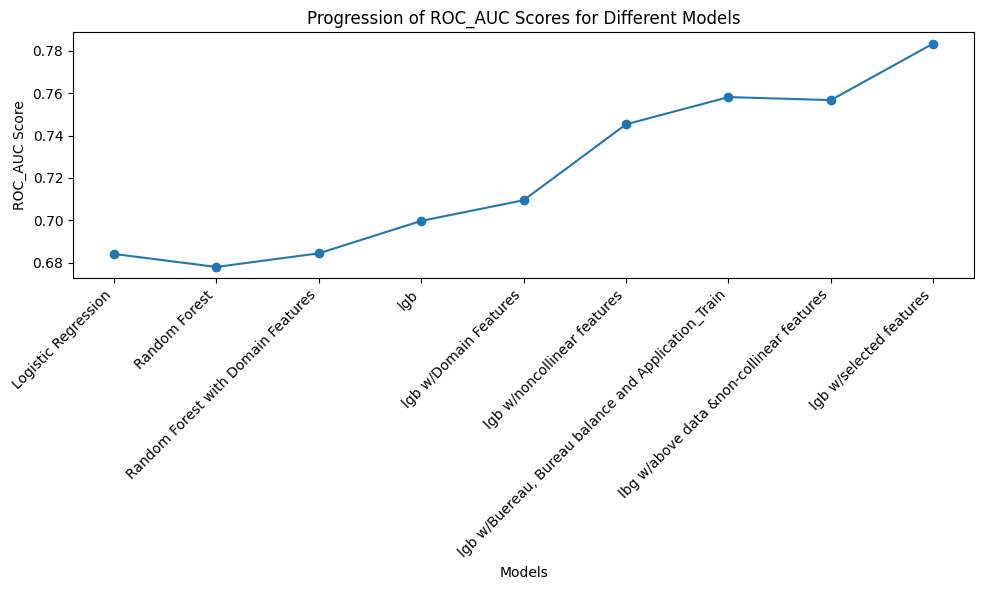

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(log.values(), marker='o', linestyle='-')

# Adding labels and title
plt.xticks(range(len(log)), list(log.keys()), rotation=45, ha='right')
plt.xlabel('Models')
plt.ylabel('ROC_AUC Score')
plt.title('Progression of ROC_AUC Scores for Different Models')

# Display the plot
plt.tight_layout()
plt.show()